# Quick Hack to Visualize Diffeomorphic Bundle Warp

This is a quick subset copied form the `dtw_test_retest_reliablity` notebook; created because original was running to calculate profile reliability

In [1]:
import os
import os.path as op
import time

from itertools import chain

import numpy as np
import pandas as pd

from AFQ import api
import AFQ.data as afd

import nibabel as nib

from dipy.io.streamline import load_tractogram
from dipy.stats.analysis import afq_profile, gaussian_weights
from dipy.tracking.streamline import set_number_of_points, values_from_volume

from scipy.interpolate import splprep, splev

from fastdtw import fastdtw

# %matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
hcp_subjects = ['103818', '105923']

def get_hcp_afq(dataset_name):
    afq = api.AFQ(
        bids_path=op.join(afd.afq_home, dataset_name),
        dmriprep='dmriprep'
    )
    
    display(afq.data_frame)
    
    return afq

hcp_test_afq = get_hcp_afq('HCP_1200')

hcp_retest_afq = get_hcp_afq('hcp_retest')

bundle_names = [*hcp_retest_afq.bundle_dict]
bundle_names = ['ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP'] 
n_points = 100

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


subject                                           dwi_file  \
0  100307  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
1  103818  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
2  105923  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   

                                           bvec_file  \
0  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
1  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   
2  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...   

                                           bval_file custom_tract reg_subject  \
0  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...         None        None   
1  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...         None        None   
2  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/d...         None        None   

  ses                                             timing  \
0  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   
1  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   
2  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   

                                         results_dir  \
0  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...   
1  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...   
2  /Users/bloomdt/AFQ_data/HCP_1200/derivatives/a...   

                                                gtab  \
0  <dipy.core.gradients.GradientTable object at 0...   
1  <dipy.core.gradients.GradientTable object at 0...   
2  <dipy.core.gradients.GradientTable object at 0...   

                                          dwi_affine  \
0  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   
1  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   
2  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   

                                             dwi_img  
0  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
1  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
2  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 
/Users/bloomdt/anaconda/envs/dtw/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


subject                                           dwi_file  \
0  103818  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   
1  105923  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   

                                           bvec_file  \
0  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   
1  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   

                                           bval_file custom_tract reg_subject  \
0  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...         None        None   
1  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...         None        None   

  ses                                             timing  \
0  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   
1  01  {'Tractography': 0, 'Registration': 0, 'Segmen...   

                                         results_dir  \
0  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   
1  /Users/bloomdt/AFQ_data/hcp_retest/derivatives...   

                                                gtab  \
0  <dipy.core.gradients.GradientTable object at 0...   
1  <dipy.core.gradients.GradientTable object at 0...   

                                          dwi_affine  \
0  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   
1  [[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...   

                                             dwi_img  
0  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...  
1  <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...

In [121]:
def get_subject_iloc(afq, subject):
    iloc = afq.data_frame.index[afq.data_frame['subject'] == subject][0]
    
    return iloc

def get_subject_scalar_data(afq, subject, scalar):
    iloc = get_subject_iloc(afq, subject)
    
    scalar_filename = afq._get_fname(
        afq.data_frame.iloc[iloc],
        f'_model-{scalar}.nii.gz'
    )

    scalar_data = nib.load(scalar_filename).get_fdata()
    
    return scalar_data

def get_subject_bundle_tractogram(afq, subject, bundle_name):
    iloc = get_subject_iloc(afq, subject)
    
    results_dir = afq.data_frame.iloc[iloc]['results_dir']
    
    fname = op.split(
        afq._get_fname(
            afq.data_frame.iloc[iloc],
            f'-{bundle_name}'
            f'_tractography.trk',
            include_track=True,
            include_seg=True
        )
    )

    tractogram_filename = op.join(results_dir, 'clean_bundles', fname[1])
    
    tractogram = load_tractogram(tractogram_filename, 'same')
    
    return tractogram

In [122]:
from itertools import chain

def plot_bundle(title, fgarray):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_title(f'{title} Streamlines (RAS mm)')
    for streamline in fgarray:
        ax.scatter3D(streamline[:,0], streamline[:,1], streamline[:,2], c=list(chain(range(0,int(len(streamline)/2)),range(int(len(streamline)/2),0,-1))), cmap='jet')
    ax.set_xlabel('x mm')
    ax.set_ylabel('y mm')
    ax.set_zlabel('z mm')
    plt.show()

In [135]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.viz import regtools

import logging

logger = logging.getLogger('dipy.align.imwarp')
logger.setLevel(logging.CRITICAL)

def get_subject_diffeomorphic_target_nodes(afq, subject, scalar_data, bundle_name):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)
        
    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)

    fgarray = set_number_of_points(tractogram.streamlines, n_points)

    values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
    mean_values = np.mean(values, axis=0)
    static = np.zeros((n, 100))

    if stack:
        for i in range(n):
            static[i] = mean_values
    else:
        static[m] = mean_values

    tic = time.perf_counter()
    target_nodes = []

#     random_streamline_idx = np.random.choice(len(tractogram.streamlines))

#     n=1 # 10
#     random_streamline_idxs = np.random.choice(len(tractogram.streamlines), size=n)
#     print(random_streamline_idxs)
    
    for value in values:
#     for streamline_idx in random_streamline_idxs:
#         value = values[streamline_idx]
        moving = np.zeros((n, 100))

        if stack:
            for i in range(n):
                moving[i] = value
        else:
            moving[m] = value

        mapping = sdr.optimize(static, moving)
        forward_field = mapping.get_forward_field()
        target_nodes.append((np.arange(100)+np.mean(forward_field, axis=0)[:,1])/100)
        
#         if np.random.choice([0, 1], size=1, p=[0.99, 0.01]):
#             regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving')
#             regtools.plot_2d_diffeomorphic_map(mapping, 10)
            
# #             lattice = mapping.transform(regtools.draw_lattice_2d(9, 9, 10), 'linear')
# #             plt.imshow(lattice, cmap=plt.cm.gray)
# #             plt.show()
# #             plt.plot(np.mean(lattice, axis=0))

        plt.plot(target_nodes[-1]*100, c='tab:blue', alpha=0.1)
        
#         warped_moving = mapping.transform(moving, 'linear')
        
#         # the extra np logic allows to handle stacked 1D images or zero padded
#         transformed_values.append(np.mean(warped_moving[np.where(np.count_nonzero(warped_moving, axis=1))], axis=0))

    plt.title(f'{subject} {bundle_name} warp map')
    plt.show()
    
    toc = time.perf_counter()
    print(f'diffeomorphic calculation {toc - tic:0.4f} seconds')

    return target_nodes

In [191]:
def get_flat_coordinates(data):
    return data.reshape(-1, data.shape[-1])

def get_cross_sectional_area(data, node_idx = -1):
    # data is 2-D nparray with length n_streamlines * n_points X 3
#     print(data.shape)

    cross_sectional_area = []    
    
    for i in range(n_points):
        # 2-D array containing positions by streamline at a given node
        # Each row of m represents a coordinate, and each column an observation
        node_data = data[i::n_points].T

        show_covariance_plot = (i == node_idx)

        if show_covariance_plot:
            print(f'node {node_idx} matrix shape', node_data.shape)
            print(f'node {node_idx} matrix rank', np.linalg.matrix_rank(node_data))

            plt.title(f'node {node_idx} covariance')
            plt.imshow(np.cov(node_data))
            plt.colorbar()
            ax = plt.gca()
            ax.set_xticks([0,1,2])
            ax.set_xticklabels(['x','y','z'])
            ax.set_yticks([0,1,2])
            ax.set_yticklabels(['x','y','z'])
            plt.show()

            print(f'covariance matrix rank', np.linalg.matrix_rank(np.cov(node_data)))
            print(f'covariance matrix trace', np.trace(np.cov(node_data)))
            print(f'determinant of covarience matrix', np.linalg.det(np.cov(node_data)))

        cross_sectional_area.append(np.linalg.det(np.cov(node_data)))
        
    return cross_sectional_area

def plot_dispersion_comparison(title, fgarray, interp_fgarray):
    cross_sectional_area = get_cross_sectional_area(fgarray.get_data())
        
    warped_cross_sectional_area = get_cross_sectional_area(
        get_flat_coordinates(interp_fgarray)
    )   
            
    plt.title(f'{title} ~ cross sectional area')
    plt.plot(cross_sectional_area, label='original')
    plt.plot(warped_cross_sectional_area, label='warped')
    plt.xlabel('node')
    plt.ylabel('~ area')
    plt.legend()
    plt.show()

### Warp Map

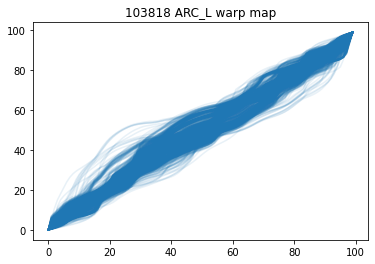

diffeomorphic calculation 1279.0285 seconds


In [136]:
n = n_points
m = int(n/2)
stack = True

scalar = 'dti_fa'
metric = CCMetric(dim=2, radius=4)

level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)

scalar_data = get_subject_scalar_data(hcp_test_afq, hcp_subjects[0], scalar)
target_nodes = get_subject_diffeomorphic_target_nodes(hcp_test_afq, hcp_subjects[0], scalar_data, bundle_names[0])

### Individual Streamline Warp Map

array([0.        , 0.0129203 , 0.02319967, 0.03213324, 0.04211892,
       0.05714389, 0.08425571, 0.10674902, 0.1192732 , 0.13178759,
       0.14553288, 0.15575692, 0.16189731, 0.16689746, 0.17154676,
       0.17636334, 0.18243704, 0.18945183, 0.19820127, 0.21031228,
       0.23248129, 0.26709077, 0.28578294, 0.29606595, 0.30416677,
       0.31204089, 0.32101818, 0.33095711, 0.34059705, 0.34941308,
       0.35744813, 0.36521133, 0.37361766, 0.38220762, 0.39006729,
       0.39723063, 0.40398133, 0.41025109, 0.41682897, 0.42388791,
       0.43131609, 0.4387402 , 0.44567003, 0.45207933, 0.45824468,
       0.46466419, 0.47180013, 0.47989553, 0.48819882, 0.49515265,
       0.50074945, 0.50545711, 0.51060429, 0.51775263, 0.53238978,
       0.56213057, 0.58314014, 0.59306603, 0.59925797, 0.6044631 ,
       0.60957727, 0.61573494, 0.62330691, 0.63254838, 0.64240832,
       0.6508785 , 0.65704662, 0.6615752 , 0.66540436, 0.66879694,
       0.67241077, 0.67782703, 0.68521443, 0.69711325, 0.71895

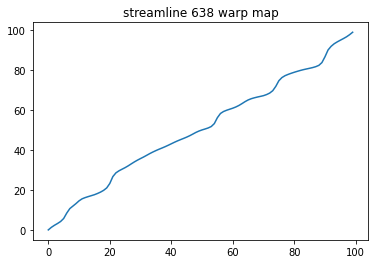

In [137]:
random_streamline_idx = np.random.choice(len(target_nodes))
display(target_nodes[random_streamline_idx])

plt.plot(target_nodes[random_streamline_idx]*100)
plt.title(f'streamline {random_streamline_idx} warp map')
plt.show()

## Plot 3D warped bundle

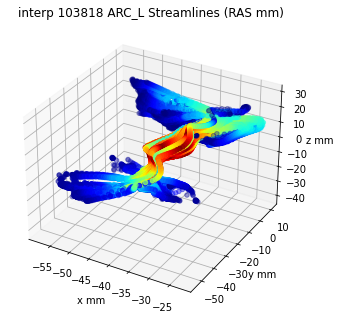

In [140]:
tractogram = get_subject_bundle_tractogram(hcp_test_afq, hcp_subjects[0],  bundle_names[0])

if len(tractogram.streamlines) == 0:
    print(subject, bundle_name, 'no streamlines!')
else:
    fgarray = set_number_of_points(tractogram.streamlines, n_points)

    interp_fgarray = [None] * len(tractogram.streamlines)

    for streamline_idx in range(len(tractogram.streamlines)):
        x = fgarray[streamline_idx][:,0]
        y = fgarray[streamline_idx][:,1]
        z = fgarray[streamline_idx][:,2]

        tck, u = splprep([x, y, z], s=0)
        new_points = splev(target_nodes[streamline_idx], tck)
        interp_fgarray[streamline_idx] = np.array(new_points).T

    plot_bundle(f'interp {hcp_subjects[0]} {bundle_names[0]}', interp_fgarray)

## Plot Dispersion

If have `interp_fgarray`

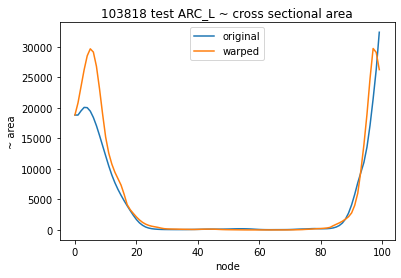

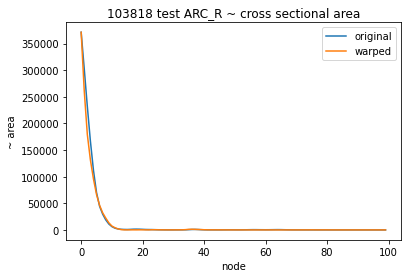

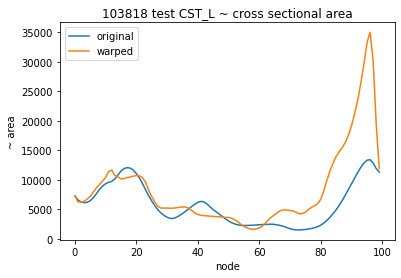

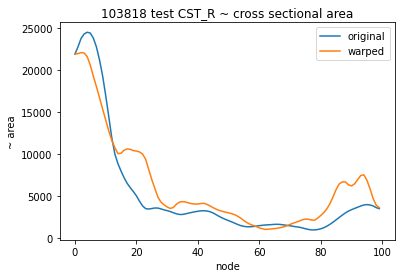

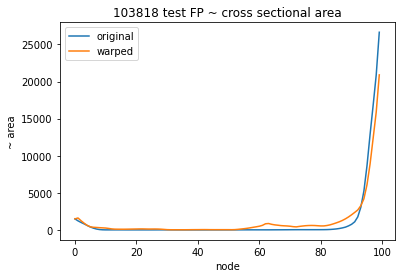

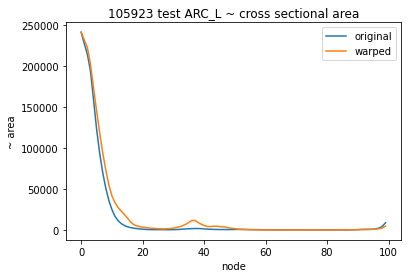

105923 ARC_R no streamlines!


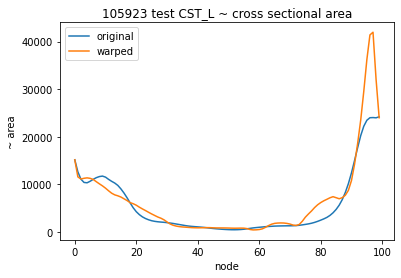

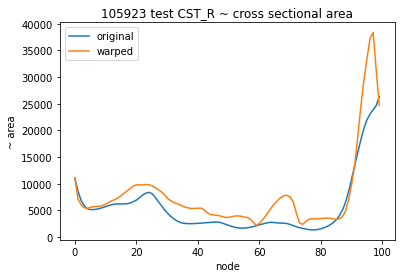

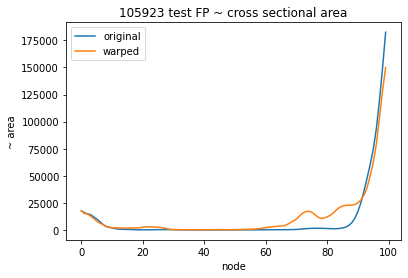

In [192]:
tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)

if len(tractogram.streamlines) == 0:
    print(subject, bundle_name, 'no streamlines!')
    continue

fgarray = set_number_of_points(tractogram.streamlines, n_points)

plot_dispersion_comparison(f'{subject} {afq_name} {bundle_name}', fgarray, np.array(interp_fgarray['test'][subject][bundle_name]))        

## Full suite

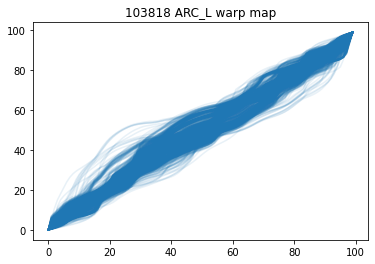

diffeomorphic calculation 1308.1408 seconds


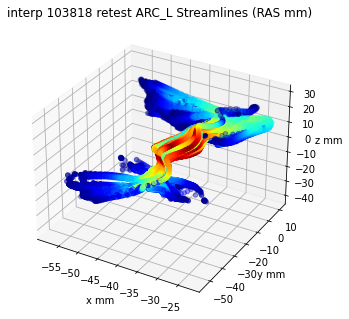

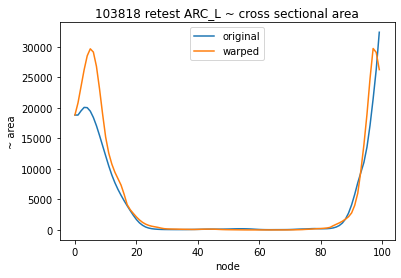

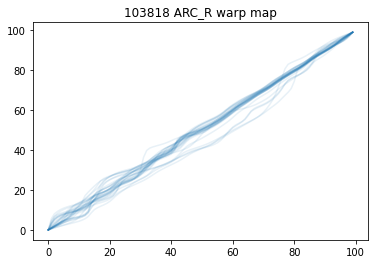

diffeomorphic calculation 30.1510 seconds


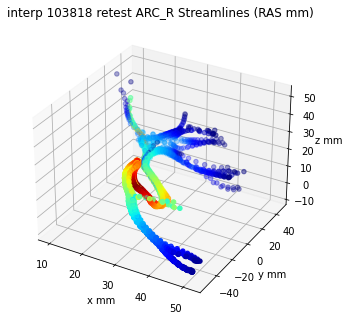

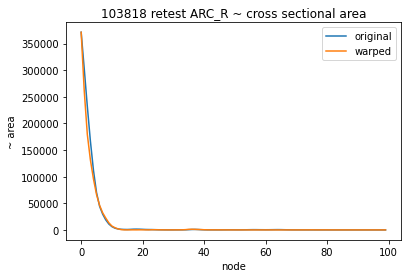

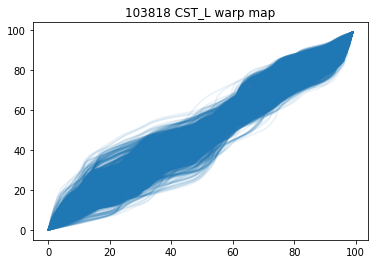

diffeomorphic calculation 2955.7880 seconds


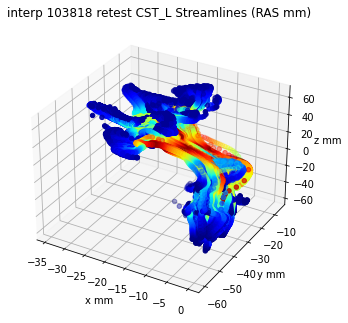

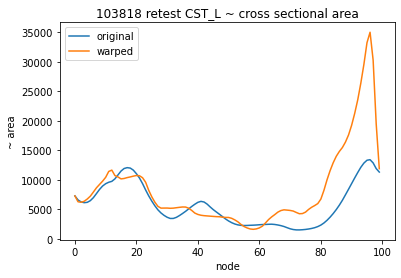

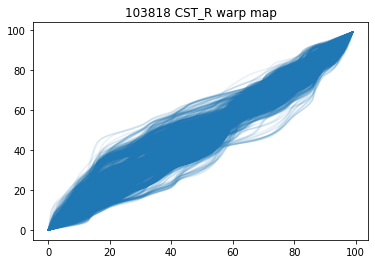

diffeomorphic calculation 2310.6891 seconds


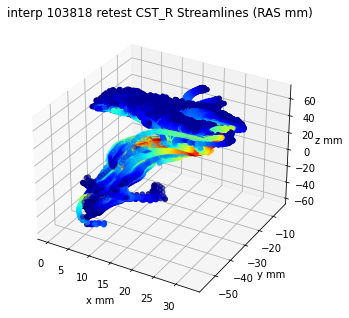

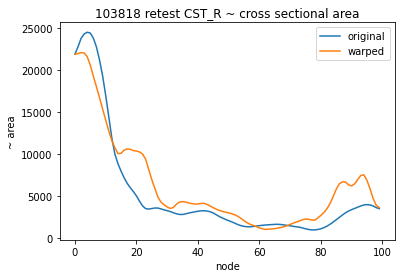

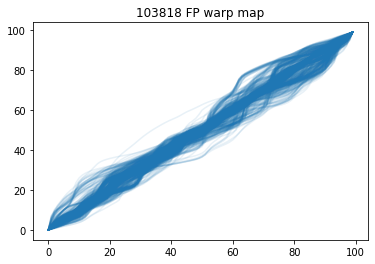

diffeomorphic calculation 652.0201 seconds


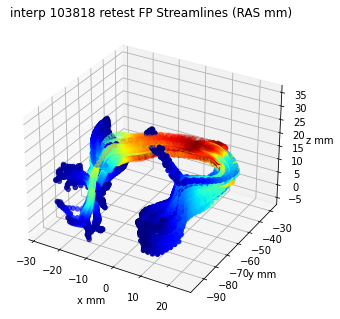

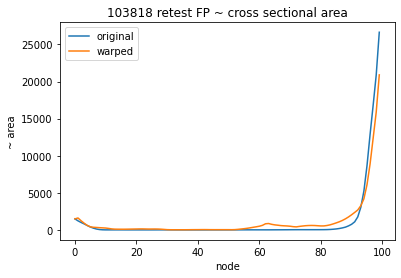

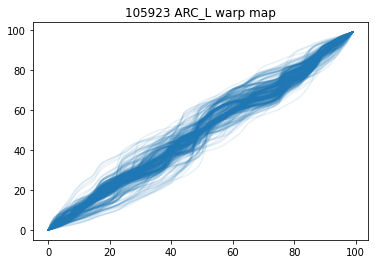

diffeomorphic calculation 448.6946 seconds


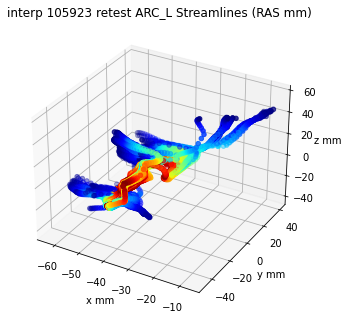

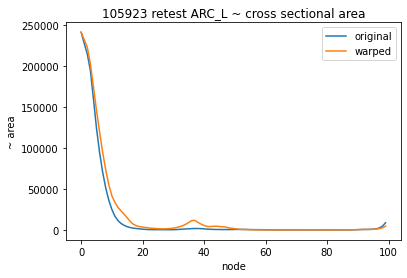

105923 ARC_R no streamlines!


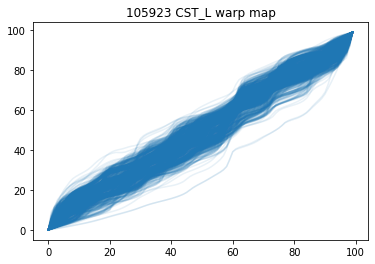

diffeomorphic calculation 1164.0949 seconds


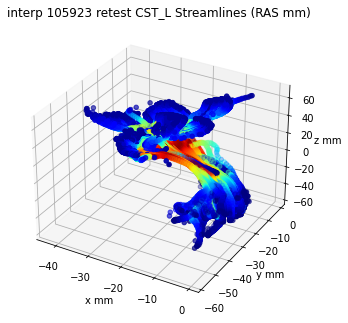

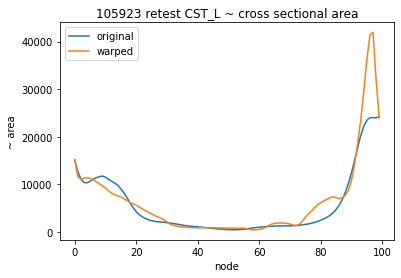

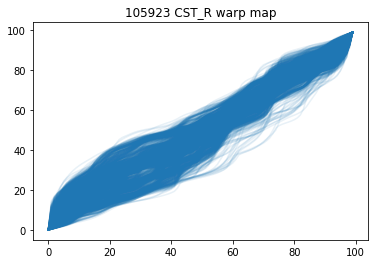

diffeomorphic calculation 2521.5168 seconds


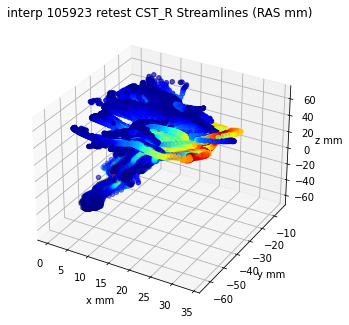

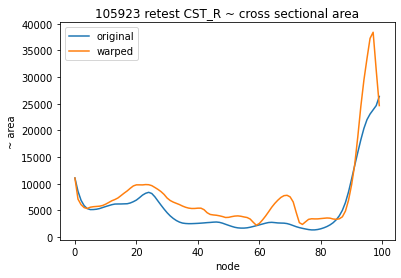

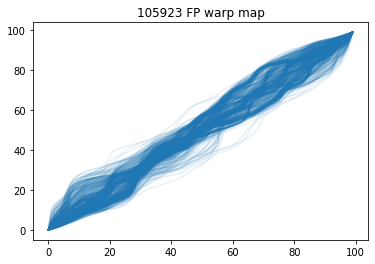

diffeomorphic calculation 778.0754 seconds


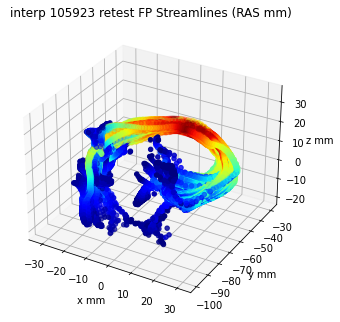

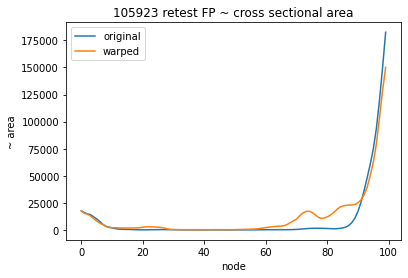

In [194]:
afq_names = ['test', 'retest']
afq_names = ['retest']

afqs = [hcp_test_afq, hcp_retest_afq]
afqs = [hcp_test_afq]

interp_fgarray = {}
for afq_name, afq in zip(afq_names, afqs):
    interp_fgarray[afq_name] = {}
    
    for subject in hcp_subjects:
        interp_fgarray[afq_name][subject] = {}
        scalar_data = get_subject_scalar_data(afq, subject, scalar)
        
        for bundle_name in bundle_names:
            tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)
            
            if len(tractogram.streamlines) == 0:
                print(subject, bundle_name, 'no streamlines!')
                continue
            
            fgarray = set_number_of_points(tractogram.streamlines, n_points)
            
            interp_fgarray[afq_name][subject][bundle_name] = [None] * len(tractogram.streamlines)
            
            target_nodes = get_subject_diffeomorphic_target_nodes(afq, subject, scalar_data, bundle_name)
            
            for streamline_idx in range(len(tractogram.streamlines)):
                x = fgarray[streamline_idx][:,0]
                y = fgarray[streamline_idx][:,1]
                z = fgarray[streamline_idx][:,2]

                tck, u = splprep([x, y, z], s=0)
                new_points = splev(target_nodes[streamline_idx], tck)
                interp_fgarray[afq_name][subject][bundle_name][streamline_idx] = np.array(new_points).T

            plot_bundle(f'interp {subject} {afq_name} {bundle_name}', interp_fgarray[afq_name][subject][bundle_name])
            plot_dispersion_comparison(f'{subject} {afq_name} {bundle_name}', fgarray, np.array(interp_fgarray[afq_name][subject][bundle_name]))

# Quick Hack Plot 10 Streamlines pre and post warp

> plot in here with the FA profiles for a random sample of 20 streamlines pre and post alignment

> add examples of individual streamlines FA profiles to the mean plot

> we can see what happens to the means

> it would be nice to see the FA profiles for individual streamlines overlaid on this

> maybe 5 or 10 in random colors with pre as a solid line and post as a dotted

In [200]:
n = n_points
m = int(n/2)
stack = True
r = 4

metric = CCMetric(dim=2, radius=4)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)

def get_subject_diffeomorphic_bundle_profile(afq, afq_name, subject, scalar, scalar_data, bundle_name):
    tractogram = get_subject_bundle_tractogram(afq, subject, bundle_name)
        
    if len(tractogram.streamlines) == 0:
        print(subject, bundle_name, 'no streamlines!')
        return np.zeros(n_points)

    fgarray = set_number_of_points(tractogram.streamlines, n_points)

    values = np.array(values_from_volume(scalar_data, fgarray, tractogram.affine))
    mean_values = np.mean(values, axis=0)
    
    plt.figure()
    plt.plot(mean_values, label='bundle $\mu$', c='k')
    
    static = np.zeros((n, 100))

    if stack:
        for i in range(n):
            static[i] = mean_values
    else:
        static[m] = mean_values

    tic = time.perf_counter()
    
    target_nodes = []
    transformed_values = []

    n_streamlines = 5
    random_streamline_idxs = np.random.choice(len(tractogram.streamlines), size=n_streamlines)
    colors = iter(plt.cm.jet(np.linspace(0,1,n_streamlines)))
    
    for streamline_idx in range(len(tractogram.streamlines)):
        value = values[streamline_idx]
        moving = np.zeros((n, 100))

        if stack:
            for i in range(n):
                moving[i] = value
        else:
            moving[m] = value  

        mapping = sdr.optimize(static, moving)

        forward_field = mapping.get_forward_field()
        target_nodes.append((np.arange(100)+np.mean(forward_field, axis=0)[:,1]))

        warped_moving = mapping.transform(moving, 'linear')
        
        # the extra np logic allows to handle stacked 1D images or zero padded
        transformed_values.append(np.mean(warped_moving[np.where(np.count_nonzero(warped_moving, axis=1))], axis=0))
        
        if streamline_idx in random_streamline_idxs:
            c=next(colors)
            plt.plot(transformed_values[-1], label='post', color=c,linestyle='dashed', alpha=0.1)
            plt.plot(value, label='pre', color=c, alpha=0.1)

    toc = time.perf_counter()
    print(f'diffeomorphic calculation {toc - tic:0.4f} seconds')
    
    target_nodes = np.array(target_nodes)
    f_name = f'HCP_{subject}_{afq_name}_{scalar}_{bundle_name}_target_nodes.npy'
    np.save(f_name, target_nodes)
    print('saving', f_name)
#     print(target_nodes.shape)
    
    transformed_values = np.array(transformed_values)
    f_name = f'HCP_{subject}_{afq_name}_{scalar}_{bundle_name}_transformed_values.npy'
    np.save(f_name, transformed_values)
    print('saving', f_name)
#     print(transformed_values.shape)

    mean_transformed_values = np.mean(transformed_values, axis=0)

    plt.plot(mean_transformed_values.T, c='k', label='bundle $\mu^{\prime}$', linestyle='dashed')
    plt.title(f'{subject} {afq_name} {scalar} {bundle_name} diffeomorhphic transform\n {n_streamlines} randomly selected streamline profiles\n stacked={stack}; n={n}; radius={r}; iters={level_iters}')
    plt.show()
    
    f_name = f'HCP_{subject}_{afq_name}_{scalar}_{bundle_name}_mean_transformed_values.npy'
    np.save(f_name, mean_transformed_values)
    print('saving', f_name)

    return mean_transformed_values

def get_diffeomorphic_bundle_profiles(afq, afq_name):
    mean_transformed_bundle_profiles = {}
    
    for subject in hcp_subjects:
        mean_transformed_bundle_profiles[subject] = {}
        iloc = get_subject_iloc(afq, subject)

        for scalar in afq.scalars:
            mean_transformed_bundle_profiles[subject][scalar] = {}
            scalar_data = get_subject_scalar_data(afq, subject, scalar)

            for bundle_name in bundle_names:
                mean_transformed_values = get_subject_diffeomorphic_bundle_profile(afq, afq_name, subject, scalar, scalar_data, bundle_name)
                mean_transformed_bundle_profiles[subject][scalar][bundle_name] = mean_transformed_values
                
    return mean_transformed_bundle_profiles

def get_test_retest_diffeomorphic_bundle_profile_correlations(show_bundle_profile=False, show_correlations=False):
    correlations = {}

    print('test')
    test_bundle_profiles = get_diffeomorphic_bundle_profiles(hcp_test_afq, 'test')
    display(pd.DataFrame.from_dict(test_bundle_profiles))

    print('retest')
    retest_bundle_profiles = get_diffeomorphic_bundle_profiles(hcp_retest_afq, 'retest')
    display(pd.DataFrame.from_dict(retest_bundle_profiles))

    for scalar in hcp_retest_afq.scalars:
        correlations[scalar] = {}
        for subject in hcp_subjects:
            correlations[scalar][subject] = {}
            for bundle_name in bundle_names:
                test_profile = test_bundle_profiles[subject][scalar][bundle_name]
                retest_profile = retest_bundle_profiles[subject][scalar][bundle_name]

                plt.figure()
                plt.title(f'{subject} {scalar} {bundle_name} bundle profiles')
                plt.plot(test_profile, label='test')
                plt.plot(retest_profile, label='retest')
                plt.xlabel('index')
                plt.ylabel(scalar)
                plt.legend()
                plt.show()

                test_retest_corr_matrix = pd.DataFrame(zip(*[test_profile, retest_profile]), columns=['test', 'retest']).corr()
                
                # select only the upper triangle off diagonals of the correlation matrix
                test_retest_corr = test_retest_corr_matrix.where(np.triu(np.ones(test_retest_corr_matrix.shape), 1).astype(np.bool)).stack()
                
                if show_correlations:
                    print(scalar, subject, bundle_name, 'test-retest correlation:\n', test_retest_corr)
                
                if len(test_retest_corr) == 1:
                    correlations[scalar][subject][bundle_name] = test_retest_corr[0]
                else:
                    correlations[scalar][subject][bundle_name] = 0
                
    return correlations

test
diffeomorphic calculation 1558.7481 seconds
saving HCP_103818_test_dti_fa_ARC_L_target_nodes.npy
saving HCP_103818_test_dti_fa_ARC_L_transformed_values.npy


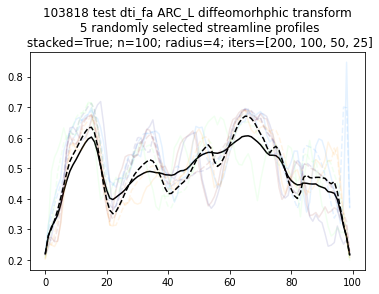

saving HCP_103818_test_dti_fa_ARC_L_mean_transformed_values.npy
diffeomorphic calculation 37.0451 seconds
saving HCP_103818_test_dti_fa_ARC_R_target_nodes.npy
saving HCP_103818_test_dti_fa_ARC_R_transformed_values.npy


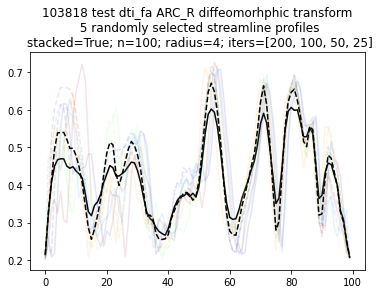

saving HCP_103818_test_dti_fa_ARC_R_mean_transformed_values.npy
diffeomorphic calculation 3612.2301 seconds
saving HCP_103818_test_dti_fa_CST_L_target_nodes.npy
saving HCP_103818_test_dti_fa_CST_L_transformed_values.npy


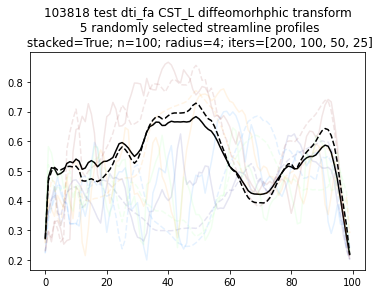

saving HCP_103818_test_dti_fa_CST_L_mean_transformed_values.npy
diffeomorphic calculation 2995.6911 seconds
saving HCP_103818_test_dti_fa_CST_R_target_nodes.npy
saving HCP_103818_test_dti_fa_CST_R_transformed_values.npy


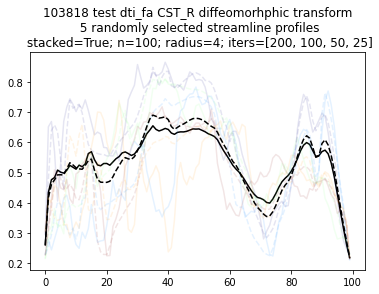

saving HCP_103818_test_dti_fa_CST_R_mean_transformed_values.npy
diffeomorphic calculation 789.1482 seconds
saving HCP_103818_test_dti_fa_FP_target_nodes.npy
saving HCP_103818_test_dti_fa_FP_transformed_values.npy


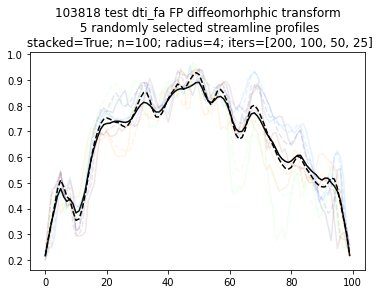

saving HCP_103818_test_dti_fa_FP_mean_transformed_values.npy
diffeomorphic calculation 1765.5787 seconds
saving HCP_103818_test_dti_md_ARC_L_target_nodes.npy
saving HCP_103818_test_dti_md_ARC_L_transformed_values.npy


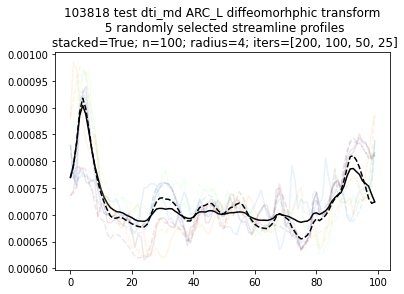

saving HCP_103818_test_dti_md_ARC_L_mean_transformed_values.npy
diffeomorphic calculation 35.8131 seconds
saving HCP_103818_test_dti_md_ARC_R_target_nodes.npy
saving HCP_103818_test_dti_md_ARC_R_transformed_values.npy


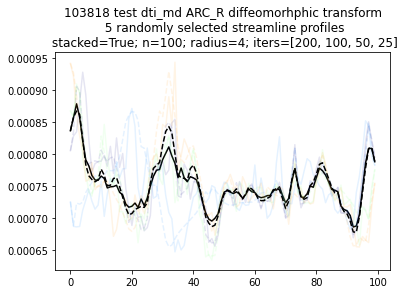

saving HCP_103818_test_dti_md_ARC_R_mean_transformed_values.npy
diffeomorphic calculation 3572.0349 seconds
saving HCP_103818_test_dti_md_CST_L_target_nodes.npy
saving HCP_103818_test_dti_md_CST_L_transformed_values.npy


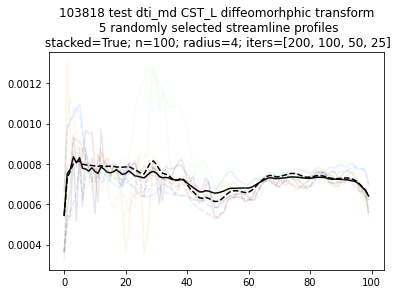

saving HCP_103818_test_dti_md_CST_L_mean_transformed_values.npy
diffeomorphic calculation 3934.2260 seconds
saving HCP_103818_test_dti_md_CST_R_target_nodes.npy
saving HCP_103818_test_dti_md_CST_R_transformed_values.npy


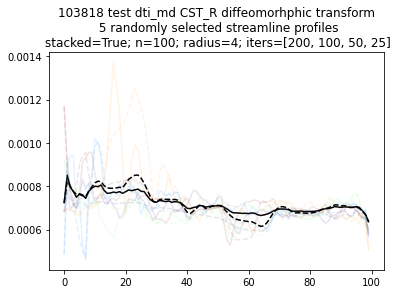

saving HCP_103818_test_dti_md_CST_R_mean_transformed_values.npy
diffeomorphic calculation 844.9102 seconds
saving HCP_103818_test_dti_md_FP_target_nodes.npy
saving HCP_103818_test_dti_md_FP_transformed_values.npy


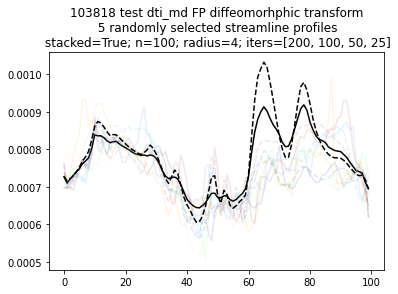

saving HCP_103818_test_dti_md_FP_mean_transformed_values.npy
diffeomorphic calculation 521.8263 seconds
saving HCP_105923_test_dti_fa_ARC_L_target_nodes.npy
saving HCP_105923_test_dti_fa_ARC_L_transformed_values.npy


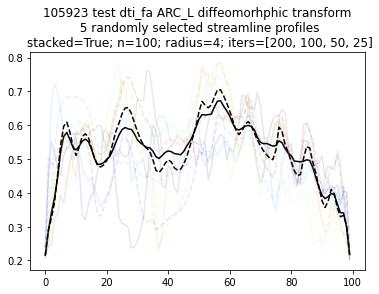

saving HCP_105923_test_dti_fa_ARC_L_mean_transformed_values.npy
105923 ARC_R no streamlines!
diffeomorphic calculation 1266.4703 seconds
saving HCP_105923_test_dti_fa_CST_L_target_nodes.npy
saving HCP_105923_test_dti_fa_CST_L_transformed_values.npy


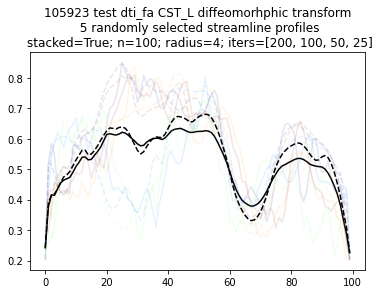

saving HCP_105923_test_dti_fa_CST_L_mean_transformed_values.npy
diffeomorphic calculation 2389.4010 seconds
saving HCP_105923_test_dti_fa_CST_R_target_nodes.npy
saving HCP_105923_test_dti_fa_CST_R_transformed_values.npy


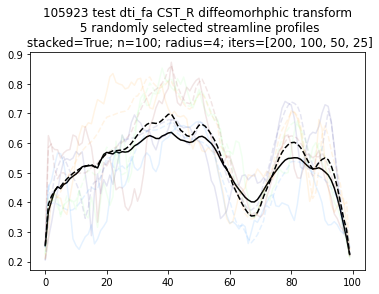

saving HCP_105923_test_dti_fa_CST_R_mean_transformed_values.npy
diffeomorphic calculation 707.8738 seconds
saving HCP_105923_test_dti_fa_FP_target_nodes.npy
saving HCP_105923_test_dti_fa_FP_transformed_values.npy


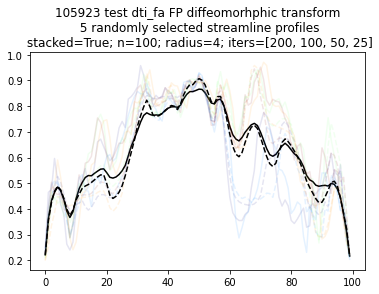

saving HCP_105923_test_dti_fa_FP_mean_transformed_values.npy
diffeomorphic calculation 597.6854 seconds
saving HCP_105923_test_dti_md_ARC_L_target_nodes.npy
saving HCP_105923_test_dti_md_ARC_L_transformed_values.npy


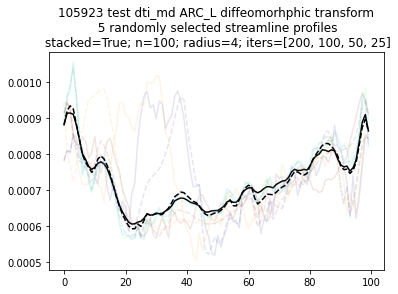

saving HCP_105923_test_dti_md_ARC_L_mean_transformed_values.npy
105923 ARC_R no streamlines!
diffeomorphic calculation 1079.3304 seconds
saving HCP_105923_test_dti_md_CST_L_target_nodes.npy
saving HCP_105923_test_dti_md_CST_L_transformed_values.npy


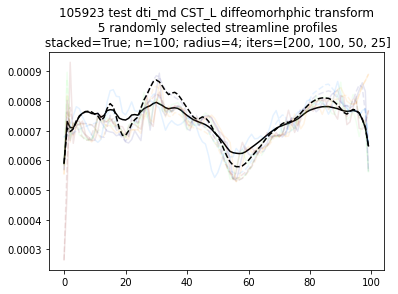

saving HCP_105923_test_dti_md_CST_L_mean_transformed_values.npy
diffeomorphic calculation 1990.6527 seconds
saving HCP_105923_test_dti_md_CST_R_target_nodes.npy
saving HCP_105923_test_dti_md_CST_R_transformed_values.npy


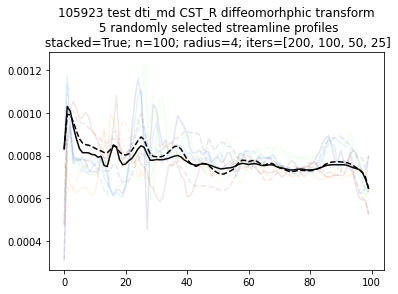

saving HCP_105923_test_dti_md_CST_R_mean_transformed_values.npy
diffeomorphic calculation 589.2049 seconds
saving HCP_105923_test_dti_md_FP_target_nodes.npy
saving HCP_105923_test_dti_md_FP_transformed_values.npy


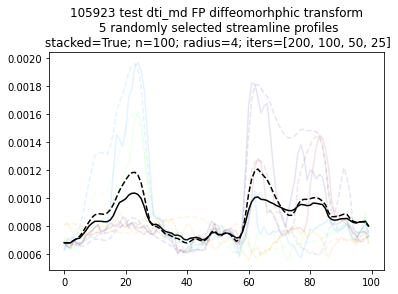

saving HCP_105923_test_dti_md_FP_mean_transformed_values.npy


103818  \
dti_fa  {'ARC_L': [0.22033323, 0.28081027, 0.30290437,...   
dti_md  {'ARC_L': [0.00076966896, 0.0007918377, 0.0008...   

                                                   105923  
dti_fa  {'ARC_L': [0.21574506, 0.28932473, 0.3265842, ...  
dti_md  {'ARC_L': [0.0008810255, 0.00092050026, 0.0009...

retest
diffeomorphic calculation 1786.4319 seconds
saving HCP_103818_retest_dti_fa_ARC_L_target_nodes.npy
saving HCP_103818_retest_dti_fa_ARC_L_transformed_values.npy


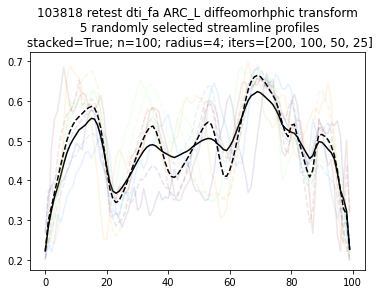

saving HCP_103818_retest_dti_fa_ARC_L_mean_transformed_values.npy
diffeomorphic calculation 147.8459 seconds
saving HCP_103818_retest_dti_fa_ARC_R_target_nodes.npy
saving HCP_103818_retest_dti_fa_ARC_R_transformed_values.npy


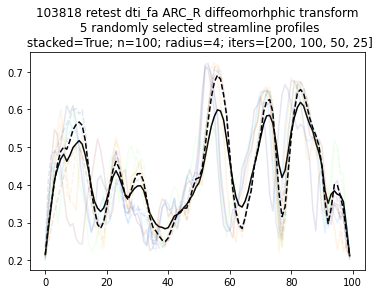

saving HCP_103818_retest_dti_fa_ARC_R_mean_transformed_values.npy
diffeomorphic calculation 3746.7919 seconds
saving HCP_103818_retest_dti_fa_CST_L_target_nodes.npy
saving HCP_103818_retest_dti_fa_CST_L_transformed_values.npy


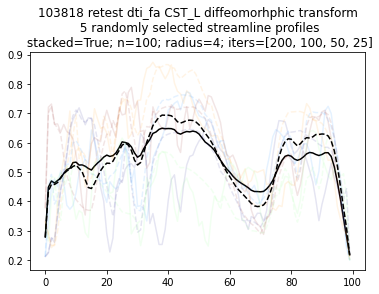

saving HCP_103818_retest_dti_fa_CST_L_mean_transformed_values.npy
diffeomorphic calculation 3030.1641 seconds
saving HCP_103818_retest_dti_fa_CST_R_target_nodes.npy
saving HCP_103818_retest_dti_fa_CST_R_transformed_values.npy


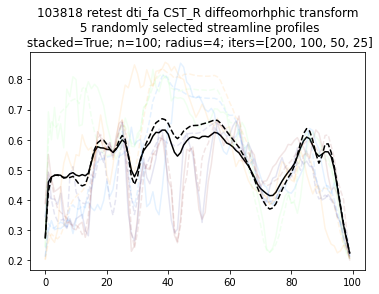

saving HCP_103818_retest_dti_fa_CST_R_mean_transformed_values.npy
diffeomorphic calculation 1193.0995 seconds
saving HCP_103818_retest_dti_fa_FP_target_nodes.npy
saving HCP_103818_retest_dti_fa_FP_transformed_values.npy


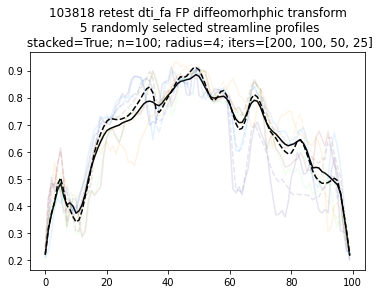

saving HCP_103818_retest_dti_fa_FP_mean_transformed_values.npy
diffeomorphic calculation 1824.5315 seconds
saving HCP_103818_retest_dti_md_ARC_L_target_nodes.npy
saving HCP_103818_retest_dti_md_ARC_L_transformed_values.npy


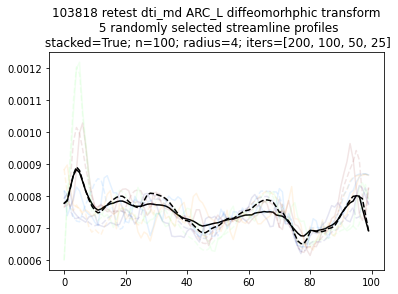

saving HCP_103818_retest_dti_md_ARC_L_mean_transformed_values.npy
diffeomorphic calculation 156.2428 seconds
saving HCP_103818_retest_dti_md_ARC_R_target_nodes.npy
saving HCP_103818_retest_dti_md_ARC_R_transformed_values.npy


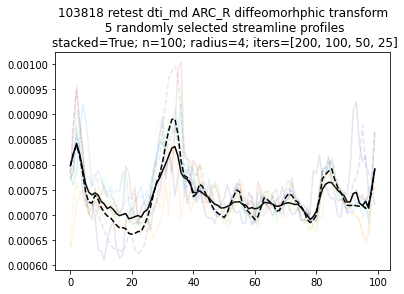

saving HCP_103818_retest_dti_md_ARC_R_mean_transformed_values.npy
diffeomorphic calculation 3665.5910 seconds
saving HCP_103818_retest_dti_md_CST_L_target_nodes.npy
saving HCP_103818_retest_dti_md_CST_L_transformed_values.npy


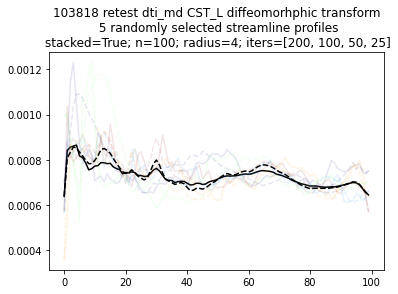

saving HCP_103818_retest_dti_md_CST_L_mean_transformed_values.npy
diffeomorphic calculation 3089.6821 seconds
saving HCP_103818_retest_dti_md_CST_R_target_nodes.npy
saving HCP_103818_retest_dti_md_CST_R_transformed_values.npy


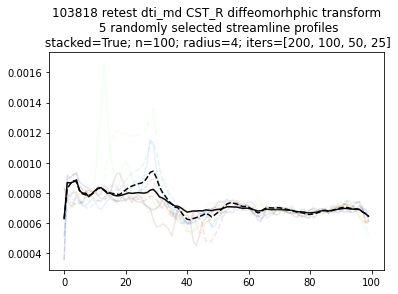

saving HCP_103818_retest_dti_md_CST_R_mean_transformed_values.npy
diffeomorphic calculation 1226.7934 seconds
saving HCP_103818_retest_dti_md_FP_target_nodes.npy
saving HCP_103818_retest_dti_md_FP_transformed_values.npy


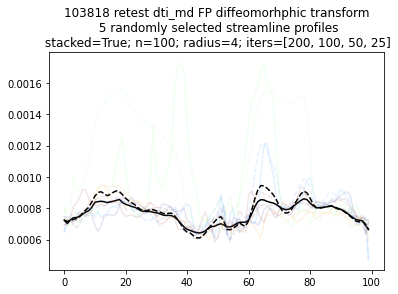

saving HCP_103818_retest_dti_md_FP_mean_transformed_values.npy
diffeomorphic calculation 356.7501 seconds
saving HCP_105923_retest_dti_fa_ARC_L_target_nodes.npy
saving HCP_105923_retest_dti_fa_ARC_L_transformed_values.npy


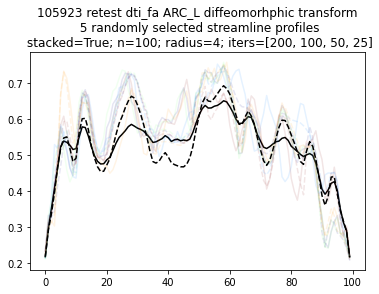

saving HCP_105923_retest_dti_fa_ARC_L_mean_transformed_values.npy
105923 ARC_R no streamlines!
diffeomorphic calculation 1722.1580 seconds
saving HCP_105923_retest_dti_fa_CST_L_target_nodes.npy
saving HCP_105923_retest_dti_fa_CST_L_transformed_values.npy


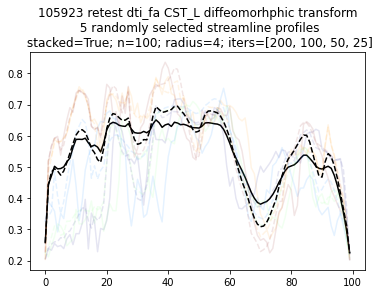

saving HCP_105923_retest_dti_fa_CST_L_mean_transformed_values.npy
diffeomorphic calculation 1963.5024 seconds
saving HCP_105923_retest_dti_fa_CST_R_target_nodes.npy
saving HCP_105923_retest_dti_fa_CST_R_transformed_values.npy


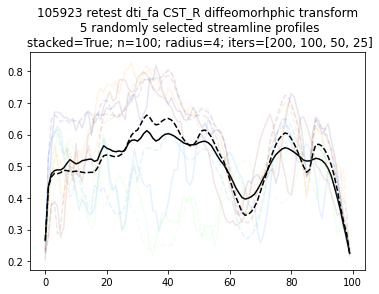

saving HCP_105923_retest_dti_fa_CST_R_mean_transformed_values.npy
diffeomorphic calculation 421.9659 seconds
saving HCP_105923_retest_dti_fa_FP_target_nodes.npy
saving HCP_105923_retest_dti_fa_FP_transformed_values.npy


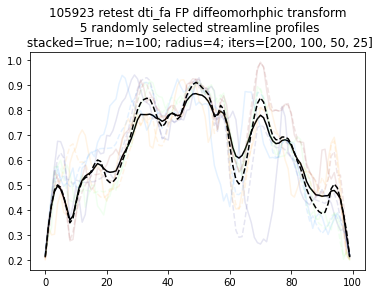

saving HCP_105923_retest_dti_fa_FP_mean_transformed_values.npy
diffeomorphic calculation 309.2833 seconds
saving HCP_105923_retest_dti_md_ARC_L_target_nodes.npy
saving HCP_105923_retest_dti_md_ARC_L_transformed_values.npy


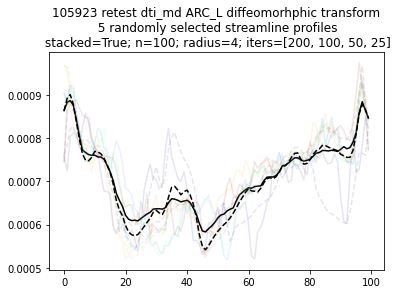

saving HCP_105923_retest_dti_md_ARC_L_mean_transformed_values.npy
105923 ARC_R no streamlines!
diffeomorphic calculation 1392.7723 seconds
saving HCP_105923_retest_dti_md_CST_L_target_nodes.npy
saving HCP_105923_retest_dti_md_CST_L_transformed_values.npy


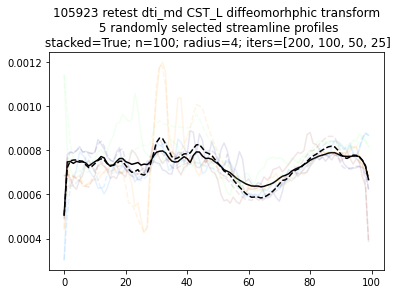

saving HCP_105923_retest_dti_md_CST_L_mean_transformed_values.npy
diffeomorphic calculation 1981.3823 seconds
saving HCP_105923_retest_dti_md_CST_R_target_nodes.npy
saving HCP_105923_retest_dti_md_CST_R_transformed_values.npy


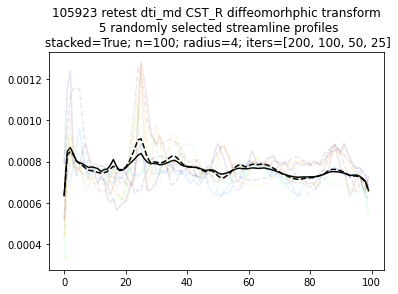

saving HCP_105923_retest_dti_md_CST_R_mean_transformed_values.npy
diffeomorphic calculation 509.8148 seconds
saving HCP_105923_retest_dti_md_FP_target_nodes.npy
saving HCP_105923_retest_dti_md_FP_transformed_values.npy


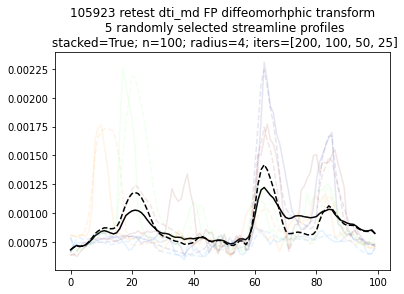

saving HCP_105923_retest_dti_md_FP_mean_transformed_values.npy


103818  \
dti_fa  {'ARC_L': [0.22229724, 0.2994249, 0.33378482, ...   
dti_md  {'ARC_L': [0.0007769264, 0.0007861417, 0.00082...   

                                                   105923  
dti_fa  {'ARC_L': [0.21692199, 0.2907766, 0.33690053, ...  
dti_md  {'ARC_L': [0.00086336496, 0.000891687, 0.00090...

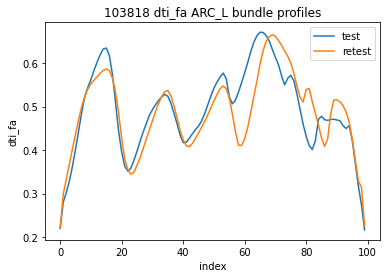

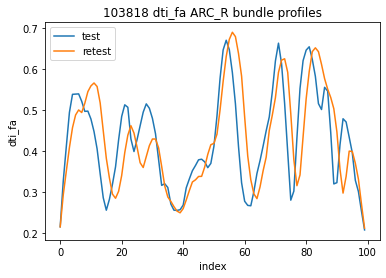

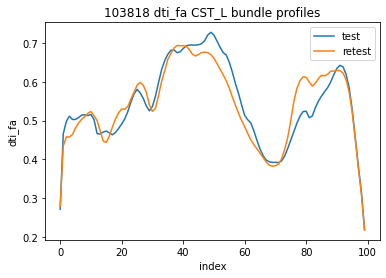

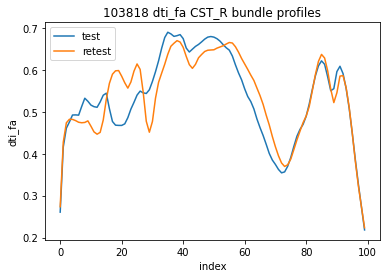

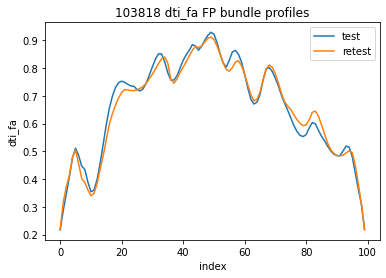

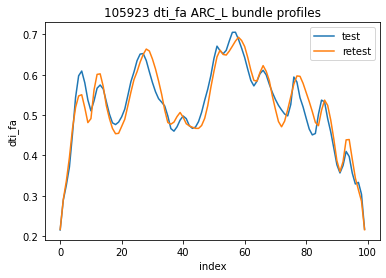

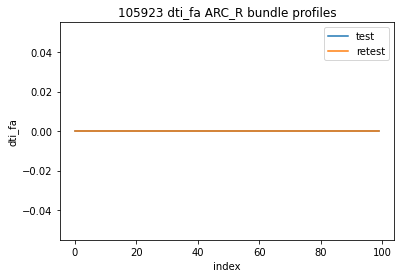

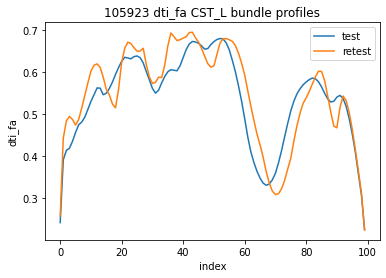

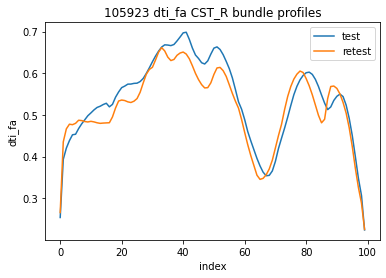

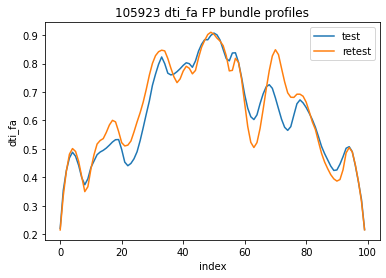

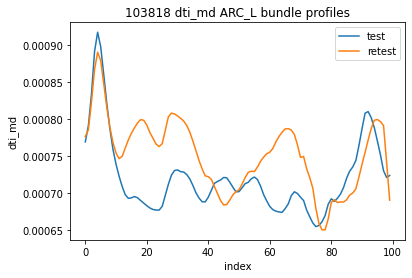

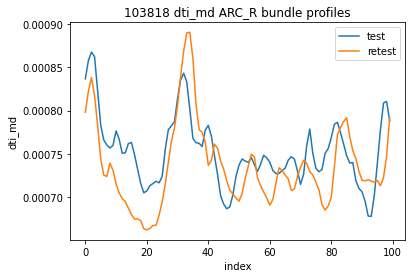

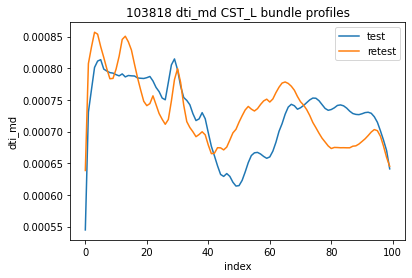

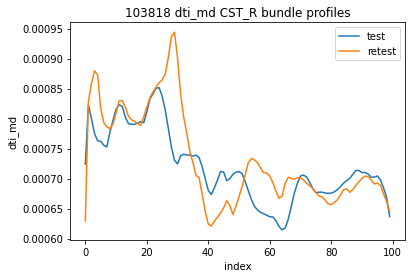

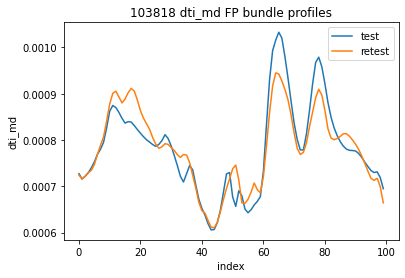

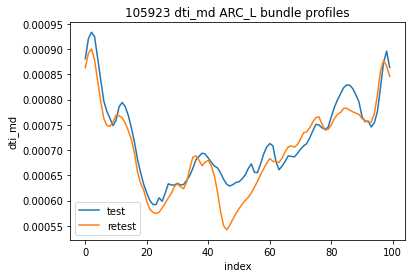

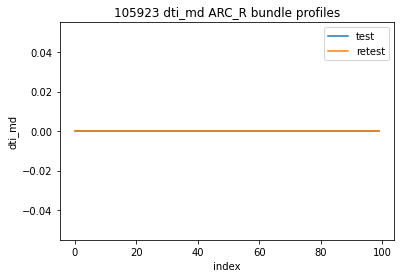

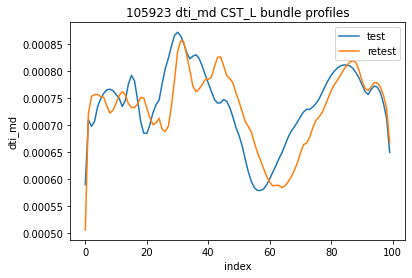

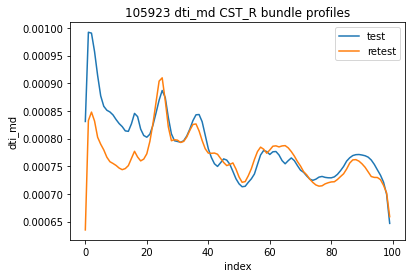

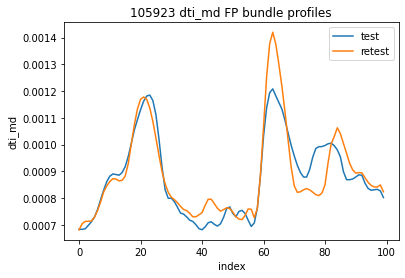

In [201]:
diffeomorphic_correlations = get_test_retest_diffeomorphic_bundle_profile_correlations()

In [202]:
diffeomorphic_correlations = np.array(diffeomorphic_correlations)
f_name = f'HCP_test_retest_diffeomorphic_correlations.npy'
np.save(f_name, diffeomorphic_correlations)
print('saving', f_name)

saving HCP_test_retest_diffeomorphic_correlations.npy
